# Sprint10 深層学習スクラッチ ディープラーニング

### インポート

In [2]:
import numpy as np

In [18]:
import matplotlib.pyplot as plt

In [19]:
from sklearn.preprocessing import OneHotEncoder

In [20]:
from sklearn.model_selection import train_test_split

In [61]:
from sklearn.metrics import accuracy_score

### データセット

In [16]:
from keras.datasets import mnist

In [17]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#### 前処理

In [21]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [22]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [23]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


#### ミニバッチクラス

In [15]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

## 【問題1】全結合層のクラス化

In [41]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2,initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W=initializer.W(n_nodes1, n_nodes2)
        self.B =initializer.B(n_nodes2)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        self.X = X
        A = np.dot(X,self.W)+self.B
        
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.B_new = np.sum(dA,axis = 0)
        self.W_new = np.dot(self.X.T,dA)
        dZ = np.dot(dA,self.W.T)

        # 更新
        self = self.optimizer.update(self)
        
        return dZ


## 【問題2】初期化方法のクラス化

In [47]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W= self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B =  np.random.randn(n_nodes2,)
        return B

## 【問題3】最適化手法のクラス化

In [27]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.W -= self.lr*layer.W_new
        layer.B -=  self.lr*layer.B_new

## 【問題4】活性化関数のクラス化

In [45]:
class Tanh():
    
    def __init__(self):
        #self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        pass
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        self.X = X
        self.A =np.tanh(X)
        
        return self.A
    
    def backward(self, dZ):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dA = dZ*(1-np.tanh(self.A)**2)

        return dA

In [46]:
class Softmax():
    
    def __init__(self):
        #self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.loss_list = []
        pass
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        #20サンプルのソフトマックス分子作成
        bunbo = np.sum(np.exp(X),axis=1)
        #20サンプル、10クラスと割り算できるようにリシェーぷ
        bunboT = np.reshape(bunbo,[X.shape[0],1])
        #ソフトマックス計算でZ3算出
        Z = np.exp(X)/bunboT
  
        return Z
    
    def backward(self, dZ,Y):
        #バックワード
        dA = dZ-Y
        #交差エントロピー
        loss = -np.sum(Y*np.log(dZ))/Y.shape[0]
        self.loss_list.append(loss)
        
        return dA,self.loss_list

## 【問題5】ReLUクラスの作成

In [101]:
class ReLU():
    
    def __init__(self):
        #self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        pass
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        self.X = X
        self.A =np.maximum(0,X)
        #self.A =np.maximum(X)
        
        return self.A
    
    def backward(self, dZ):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dA = np.where((dZ > 0) ,1,0)

        return dA

In [3]:
y_2 = np.array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1,1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [6]:
print(np.where((y_2 > 0) ,1,0))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]


## 【問題6】重みの初期値

In [100]:
class XavierInitializer:
    """
    ザビエルによるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, n_nodes1):
        self.sigma = 1/np.sqrt(n_nodes1)
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W=  self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B =  np.random.randn(n_nodes2,)
        return B

In [87]:
class HeInitializer:
    """
    Heによるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W= np.sqrt(2/n_nodes1) * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B =  np.random.randn(n_nodes2,)
        return B

## 【問題7】最適化手法

In [175]:
class AdaGrad() :
    """
    AdaGrad 
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr,batchi_sumple):
        self.lr = lr
        self.batchi_sumple = batchi_sumple

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        #新しい更新式
        
        self.H_w =  layer.W_new**2
        self.H_w += self.H_w /self.batchi_sumple
        layer.W -=  self.lr*np.sqrt(self.H_w)*layer.W_new
        
        self.B_w =  layer.B_new**2
        self.B_w += self.B_w /self.batchi_sumple
        layer.B -=  self.lr*np.sqrt(self.B_w)*layer.B_new

## 【問題8】クラスの完成

In [53]:
class ScratchDeepNeuralNetrowkClassifier():
    
    def __init__(self, iter_num = 100,verbose = True,α=0.00001,n_features = 784,n_nodes1 = 400,sigma = 0.01,n_nodes2 = 200,n_output = 10,batchi_sumple=20):
        self.verbose = verbose
        self.lr = α
        self.n_features =n_features
        self.n_nodes1 = n_nodes1
        self.sigma = sigma
        self.n_nodes2=n_nodes2
        self.n_output=n_output
        self.batchi_sumple =batchi_sumple
        self.iter_num = iter_num
        
        pass
    
    
    def fit(self, X, y, X_val=None, y_val=None):
        #インスタンス化
        optimizer = SGD(self.lr)
        self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        self.activation1 = Tanh()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        self.activation2 = Tanh()
        self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        self.activation3 = Softmax()
        
        #データを取得
        get_mini_batch = GetMiniBatch(X, y, batch_size=self.batchi_sumple)
        #ロスのリスト作成
        loss_list = []
        
        for i in range(self.iter_num):
            for mini_X_train, mini_y_train in get_mini_batch:
                #フォワード
                A1 = self.FC1.forward(mini_X_train)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                #バックワード
                dA3,loss_list = self.activation3.backward(Z3, mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) 
                
        return loss_list
    
    def predict(self, X):
         #フォワード
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)

        pred = np.argmax(Z3,axis = 1)

        return pred
    

## 【問題9】学習と推定

In [54]:
#インスタンス化
DNN =ScratchDeepNeuralNetrowkClassifier()

In [55]:
loss_list = DNN.fit(X_train, y_train)

In [56]:
aaaa = np.arange(0,len(loss_list))

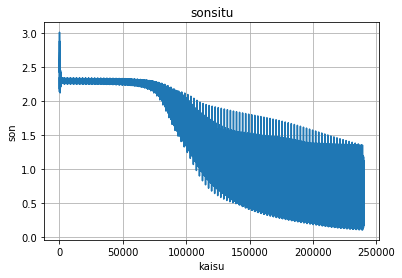

In [57]:
plt.title("sonsitu")
plt.xlabel('kaisu')
plt.ylabel('son')
plt.grid()
plt.plot(aaaa,loss_list)
plt.show()

In [59]:
#プレディクト
pred_val = DNN.predict(X_val)

In [64]:
y_test = np.argmax(y_val,axis = 1)

In [65]:
#アキュラシー算出
print(accuracy_score(y_test, pred_val))

0.8554166666666667


### とりあえずNNで作った条件のクラスがうまく動いたので色々なパターンで試してみる

#### 層を3→5に

In [82]:
#単純に層を増やしてみる（3→5)

class ScratchDeepNeuralNetrowkClassifier_sou5():
    
    def __init__(self, iter_num = 100,verbose = True,α=0.00001,n_features = 784,n_nodes1 = 700,sigma = 0.01,n_nodes2 = 500,n_output = 10,batchi_sumple=20,n_nodes3 = 300, n_nodes4 = 100):
        self.verbose = verbose
        self.lr = α
        self.n_features =n_features
        self.n_nodes1 = n_nodes1
        self.sigma = sigma
        self.n_nodes2=n_nodes2
        self.n_output=n_output
        self.batchi_sumple =batchi_sumple
        self.iter_num = iter_num
        #ノード追加
        self.n_nodes3=n_nodes3
        self.n_nodes4=n_nodes4
        
        
        pass
    
    
    def fit(self, X, y, X_val=None, y_val=None):
        #インスタンス化
        optimizer = SGD(self.lr)
        self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        self.activation1 = Tanh()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        self.activation2 = Tanh()
        #追加
        self.FC3 = FC(self.n_nodes2, self.n_nodes3, SimpleInitializer(self.sigma), optimizer)
        self.activation3 = Tanh()
        self.FC4 = FC(self.n_nodes3, self.n_nodes4, SimpleInitializer(self.sigma), optimizer)
        self.activation4 = Tanh()        
        self.FC5 = FC(self.n_nodes4, self.n_output, SimpleInitializer(self.sigma), optimizer)
        self.activation5 = Softmax()
        
        #データを取得
        get_mini_batch = GetMiniBatch(X, y, batch_size=self.batchi_sumple)
        #ロスのリスト作成
        loss_list = []
        
        for i in range(self.iter_num):
            for mini_X_train, mini_y_train in get_mini_batch:
                #フォワード
                A1 = self.FC1.forward(mini_X_train)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                #追加
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                A4 = self.FC4.forward(Z3)
                Z4 = self.activation4.forward(A4)
                #最終
                A5 = self.FC5.forward(Z4)
                Z5 = self.activation5.forward(A5)
                
                #バックワード
                dA5,loss_list = self.activation5.backward(Z5, mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ4 = self.FC5.backward(dA5)
                #追加
                dA4 = self.activation4.backward(dZ4)
                dZ3 = self.FC4.backward(dA4)
                dA3 = self.activation3.backward(dZ3)
                dZ2 = self.FC3.backward(dA3)
                #
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) 
                
        return loss_list
    
    def predict(self, X):
         #フォワード
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        A4 = self.FC4.forward(Z3)
        Z4 = self.activation4.forward(A4)
        #最終
        A5 = self.FC5.forward(Z4)
        Z5 = self.activation5.forward(A5)

        pred = np.argmax(Z5,axis = 1)

        return pred
    

In [83]:
#インスタンス化
DNN5 =ScratchDeepNeuralNetrowkClassifier_sou5()

In [84]:
loss_list5= DNN5.fit(X_train, y_train)

In [89]:
#プレディクト
pred_val5 = DNN5.predict(X_val)

In [90]:
#アキュラシー算出
print(accuracy_score(y_test, pred_val5))

0.11341666666666667


In [91]:
aaaa5 = np.arange(0,len(loss_list5))

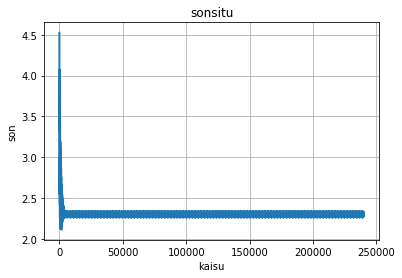

In [92]:
plt.title("sonsitu")
plt.xlabel('kaisu')
plt.ylabel('son')
plt.grid()
plt.plot(aaaa5,loss_list5)
plt.show()

In [93]:
pred_val5_train = DNN5.predict(X_train)

In [95]:
y_test_2 = np.argmax(y_train,axis = 1)

In [96]:
print(accuracy_score(y_test_2, pred_val5_train))

0.11210416666666667


In [97]:
#全然精度でなかった。きっと何かがおかしい

#### 重みサビエル

In [105]:
class ScratchDeepNeuralNetrowkClassifier_iniX():
    
    def __init__(self, iter_num = 100,verbose = True,α=0.00001,n_features = 784,n_nodes1 = 400,sigma = 0.01,n_nodes2 = 200,n_output = 10,batchi_sumple=20):
        self.verbose = verbose
        self.lr = α
        self.n_features =n_features
        self.n_nodes1 = n_nodes1
        self.sigma = sigma
        self.n_nodes2=n_nodes2
        self.n_output=n_output
        self.batchi_sumple =batchi_sumple
        self.iter_num = iter_num
        
        pass
    
    
    def fit(self, X, y, X_val=None, y_val=None):
        #インスタンス化
        optimizer = SGD(self.lr)
        #イニシャライザーをザビエルに
        self.FC1 = FC(self.n_features, self.n_nodes1, XavierInitializer(self.n_nodes1), optimizer)
        self.activation1 = Tanh()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, XavierInitializer(self.n_nodes1), optimizer)
        self.activation2 = Tanh()
        self.FC3 = FC(self.n_nodes2, self.n_output, XavierInitializer(self.n_nodes1), optimizer)
        self.activation3 = Softmax()
        
        #データを取得
        get_mini_batch = GetMiniBatch(X, y, batch_size=self.batchi_sumple)
        #ロスのリスト作成
        loss_list = []
        
        for i in range(self.iter_num):
            for mini_X_train, mini_y_train in get_mini_batch:
                #フォワード
                A1 = self.FC1.forward(mini_X_train)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                #バックワード
                dA3,loss_list = self.activation3.backward(Z3, mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) 
                
        return loss_list
    
    def predict(self, X):
         #フォワード
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)

        pred = np.argmax(Z3,axis = 1)

        return pred
    

In [106]:
#インスタンス化
DNNiniX =ScratchDeepNeuralNetrowkClassifier_iniX()

In [107]:
#フィット
loss_list_iniX= DNNiniX.fit(X_train, y_train)

In [108]:
#プレディクト
pred_val5_iniX = DNNiniX.predict(X_val)

In [109]:
#アキュラシー算出
print(accuracy_score(y_test, pred_val5_iniX))

0.913


In [110]:
aaaa_iniX = np.arange(0,len(loss_list_iniX))

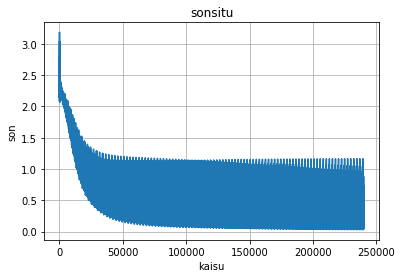

In [111]:
plt.title("sonsitu")
plt.xlabel('kaisu')
plt.ylabel('son')
plt.grid()
plt.plot(aaaa_iniX,loss_list_iniX)
plt.show()

In [ ]:
#85から91まで上がった！

#### 最適化クラスAdaGrad

In [183]:
#最適化手法のクラスを変えてみる
class ScratchDeepNeuralNetrowkClassifier_adaG():
    
    def __init__(self, iter_num = 100,verbose = True,α=0.00001,n_features = 784,n_nodes1 = 400,sigma = 0.01,n_nodes2 = 200,n_output = 10,batchi_sumple=20):
        self.verbose = verbose
        self.lr = α
        self.n_features =n_features
        self.n_nodes1 = n_nodes1
        self.sigma = sigma
        self.n_nodes2=n_nodes2
        self.n_output=n_output
        self.batchi_sumple =batchi_sumple
        self.iter_num = iter_num
        
        self.H_w = 0
        self.B_w = 0


        pass
    
    
    def fit(self, X, y, X_val=None, y_val=None):
        #インスタンス化
        #変更
        optimizer = AdaGrad(self.lr,self.batchi_sumple)
        self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        self.activation1 = Tanh()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        self.activation2 = Tanh()
        self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        self.activation3 = Softmax()
        
        #データを取得
        get_mini_batch = GetMiniBatch(X, y, batch_size=self.batchi_sumple)
        #ロスのリスト作成
        loss_list = []
        
        
        for i in range(self.iter_num):
            for mini_X_train, mini_y_train in get_mini_batch:
                #フォワード
                A1 = self.FC1.forward(mini_X_train)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                #バックワード
                dA3,loss_list = self.activation3.backward(Z3, mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) 
                
        return loss_list
    
    def predict(self, X):
         #フォワード
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)

        pred = np.argmax(Z3,axis = 1)

        return pred

In [184]:
#インスタンス化
DNN_adaG =ScratchDeepNeuralNetrowkClassifier_adaG()

In [185]:
#フィット
loss_list_adaG= DNN_adaG.fit(X_train, y_train)

In [186]:
#プレディクト
pred_iniX = DNN_adaG.predict(X_val)

In [187]:
#アキュラシー算出
print(accuracy_score(y_test, pred_iniX))

0.21008333333333334


In [188]:
aaaa_adaG = np.arange(0,len(loss_list_adaG))

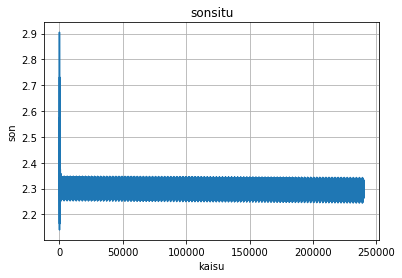

In [189]:
plt.title("sonsitu")
plt.xlabel('kaisu')
plt.ylabel('son')
plt.grid()
plt.plot(aaaa_adaG,loss_list_adaG)
plt.show()

In [ ]:
#

#### 活性化関数ReLU

In [112]:
#活性化関数のクラスを変えてみる
class ScratchDeepNeuralNetrowkClassifier_relu():
    
    def __init__(self, iter_num = 100,verbose = True,α=0.00001,n_features = 784,n_nodes1 = 400,sigma = 0.01,n_nodes2 = 200,n_output = 10,batchi_sumple=20):
        self.verbose = verbose
        self.lr = α
        self.n_features =n_features
        self.n_nodes1 = n_nodes1
        self.sigma = sigma
        self.n_nodes2=n_nodes2
        self.n_output=n_output
        self.batchi_sumple =batchi_sumple
        self.iter_num = iter_num
        
        pass
    
    
    def fit(self, X, y, X_val=None, y_val=None):
        #インスタンス化
        optimizer = SGD(self.lr)
        self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        self.activation1 = ReLU()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        self.activation2 = ReLU()
        self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        self.activation3 = Softmax()
        
        #データを取得
        get_mini_batch = GetMiniBatch(X, y, batch_size=self.batchi_sumple)
        #ロスのリスト作成
        loss_list = []
        
        for i in range(self.iter_num):
            for mini_X_train, mini_y_train in get_mini_batch:
                #フォワード
                A1 = self.FC1.forward(mini_X_train)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                #バックワード
                dA3,loss_list = self.activation3.backward(Z3, mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) 
                
        return loss_list
    
    def predict(self, X):
         #フォワード
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)

        pred = np.argmax(Z3,axis = 1)

        return pred

In [113]:
#インスタンス化
DNN_relu =ScratchDeepNeuralNetrowkClassifier_relu()

In [114]:
#フィット
loss_list_relu= DNN_relu.fit(X_train, y_train)

In [115]:
#プレディクト
pred_relu= DNN_relu.predict(X_val)

In [116]:
#アキュラシー算出
print(accuracy_score(y_test, pred_relu))

0.11341666666666667


In [117]:
aaaa_relu = np.arange(0,len(loss_list_relu))

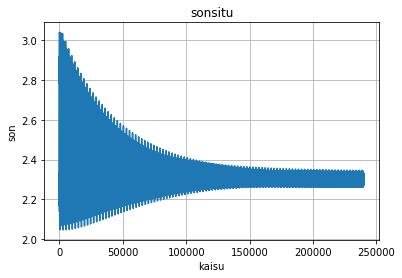

In [118]:
plt.title("sonsitu")
plt.xlabel('kaisu')
plt.ylabel('son')
plt.grid()
plt.plot(aaaa_relu,loss_list_relu)
plt.show()

In [119]:
#下がった　